# Introduction

Compare how the 10x minimal annotation experiments performed. (It's mostly protein, linc, and antisense genes left

In [1]:
import numpy
import scanpy
import anndata
import os
import pandas
from matplotlib import pyplot
from matplotlib import cm
import scipy
from pathlib import Path
import upsetplot
import louvain
import sklearn
import seaborn
import logging

from pipeline_common import get_gene_id_to_name, load_gtf
#from cuml.decomposition import PCA
#from cuml.manifold import TSNE


In [2]:
analysis_dir = Path('ENCSR874BOF_e10_5_minimal_limb')

In [3]:
ls $analysis_dir/*.h5ad

ENCSR874BOF_e10_5_minimal_limb/alevin_decoy.h5ad
ENCSR874BOF_e10_5_minimal_limb/alevin.h5ad
ENCSR874BOF_e10_5_minimal_limb/cellranger_filtered.h5ad
ENCSR874BOF_e10_5_minimal_limb/kallisto_filtered.h5ad
ENCSR874BOF_e10_5_minimal_limb/solo_filtered.h5ad


In [4]:
tenx_datasets = {
    'cellranger': scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/cellranger_filtered.h5ad').to_df().T,
    'solo': scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/solo_filtered.h5ad').to_df().T,
    'alevin': scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/alevin.h5ad').to_df().T,
    'kallisto': scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/kallisto_filtered.h5ad').to_df().T,
}

In [5]:
tenx_datasets['cellranger']

,GCGAGAAGTCATCGGC,AGAATAGGTCTTGTCC,TTATGCTTCCAGATCA,TGCTACCAGCCAGTAG,AGGGAGTGTCTGGAGA,CATGACACAGTGACAG,GCGCAACGTGCACTTA,GTGTGCGGTCCTGCTT,GGCAATTTCTCACATT,GACGCGTTCGGATGGA,...,CTCACACAGACCTTTG,GCGCCAAGTACTTCTT,GGAGCAACACGGCTAC,AATCCAGGTAAGTGGC,CACCACTTCTCTTGAT,GTCTTCGAGACAGAGA,GCCAAATTCTTACCTA,GCACATAGTCTCCCTA,TGTGGTAAGGATCGCA,CAACTAGCATAGACTC
ENSMUSG00000051951.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000089699.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000102343.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000025900.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000025902.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gSpikein_ERCC-00165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gSpikein_ERCC-00168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gSpikein_ERCC-00170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gSpikein_ERCC-00171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compute Spearman functions

In [6]:
def compute_spearman_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


In [7]:
def compute_spearman_anndata(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    obs_names = left.obs_names
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.X.todense()
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.X.todense()

    #print(left.shape[0])
    #print(left[0].shape)
    #print(right[0].shape)
    cors=[]
    for i in range(left.shape[0]):
        cors.append(scipy.stats.spearmanr(left[:,i], right[:,i])[0])
    cors = pandas.Series(cors, index=obs_names)
    #[~numpy.isnan(cors)]
    return cors


In [8]:
cr = compute_spearman_pandas(tenx_datasets['cellranger'], tenx_datasets['solo'])
print('raw', len(cr))
print('filtered', len(cr[~numpy.isnan(cr)]))

raw 6289
filtered 6289


In [9]:
def compute_correlations(tables):
    programs = list(tables.keys())
    cell_correlations = {}

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            assert tables[name_x].shape == tables[name_y].shape
            cs_cors = compute_spearman_pandas(tables[name_x], tables[name_y])
            assert len(cs_cors) == len(tables[name_x].columns)
            cell_correlations.setdefault(name_x, {})[name_y] = cs_cors
    return cell_correlations

In [10]:
tenx_cors = compute_correlations(tenx_datasets)

In [11]:
tenx_cors['cellranger']['solo'].shape

(6289,)

In [12]:
def plot_cell_correlation_histogram(table, *, programs=None, bins=50):
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(7,7))
    f.suptitle('Spearman')
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            spearman = table[name_x][name_y]
            spearman = numpy.array(spearman)
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCount {count}', xy=(0.1, 0.6), xycoords='axes fraction')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    #f.tight_layout()

# 10x minimal correlation histograms

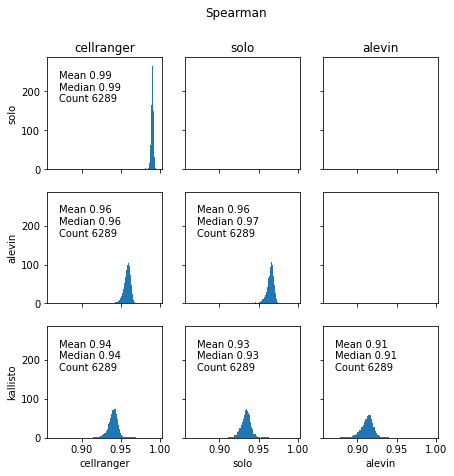

In [13]:
plot_cell_correlation_histogram(tenx_cors)

In [14]:
def sc_scatter(table, correlations, name_x, name_y, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    #x_cells = numpy.asarray(table[name_x][cell_id].X.todense())
    #y_cells = numpy.asarray(table[name_y][cell_id].X.todense())
    ax.scatter(table[name_x][cell_id]+0.01, table[name_y][cell_id]+0.01, color=colors, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    count = numpy.sum((table[name_x][cell_id] > 0) & (table[name_y][cell_id] > 0))
    ax.set_title(f'id {cell_id}\n{spearman:0.4}\nCount: {count}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


In [15]:
def show_scatter_extremes(dense_mat, correlations, name_x, name_y):
    scores = correlations[name_x][name_y]
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    #print(best_cell, worst_cell, median_cell)
    
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1,3, sharex=True, sharey=True)
    sc_scatter(dense_mat, correlations, name_x, name_y, worst_cell, ax=axes[0])
    sc_scatter(dense_mat, correlations, name_x, name_y, median_cell, ax=axes[1])
    sc_scatter(dense_mat, correlations, name_x, name_y, best_cell, ax=axes[2])

Show scatter plots of two algorithms on the same cell, I chose the worst, median, and best spearman correlations. The header is cell ID, spearmen correlation, and how many gtf annotations are shown on the plot. Points colored red are the ERCC spike ins

## 10x minimal cellranger vs star solo

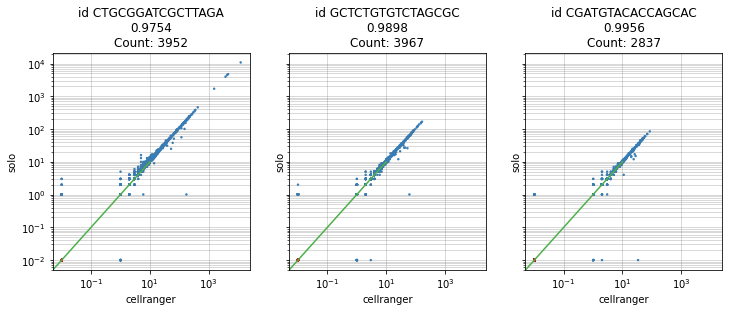

In [18]:
show_scatter_extremes(tenx_datasets, tenx_cors, 'cellranger', 'solo')

## 10x minimal cellranger vs alevin

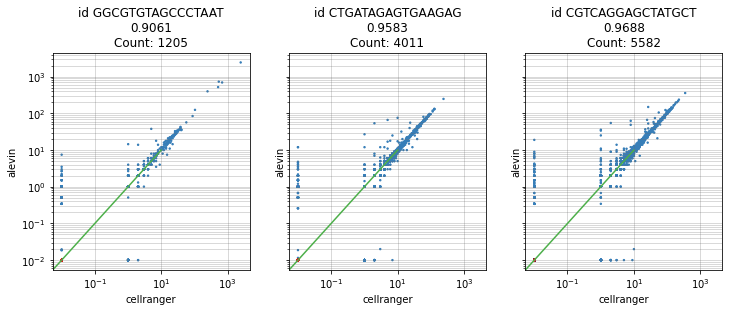

In [19]:
show_scatter_extremes(tenx_datasets, tenx_cors, 'cellranger', 'alevin')

## 10x minimal cellranger vs kallisto

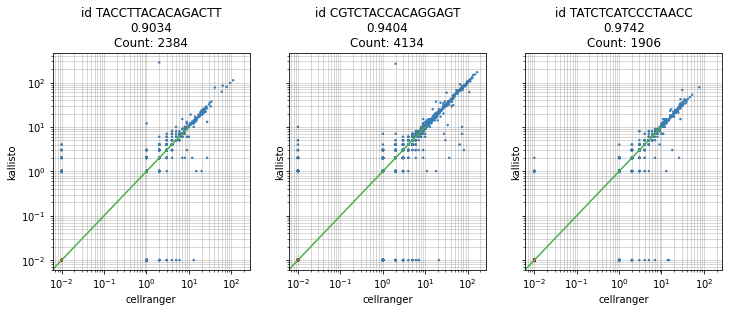

In [20]:
show_scatter_extremes(tenx_datasets, tenx_cors, 'cellranger', 'kallisto')

## 10x minimal star solo vs alevin

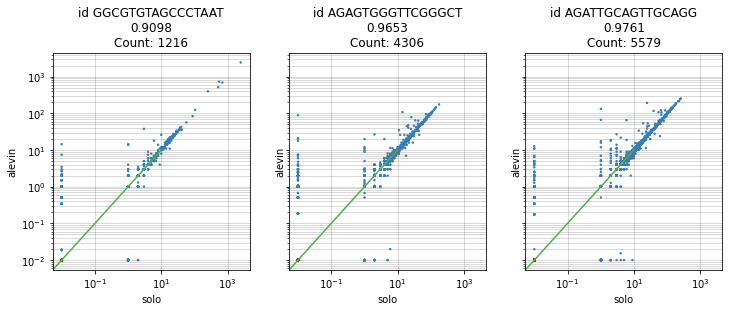

In [21]:
show_scatter_extremes(tenx_datasets, tenx_cors, 'solo', 'alevin')

## 10x minimal star solo vs kallisto

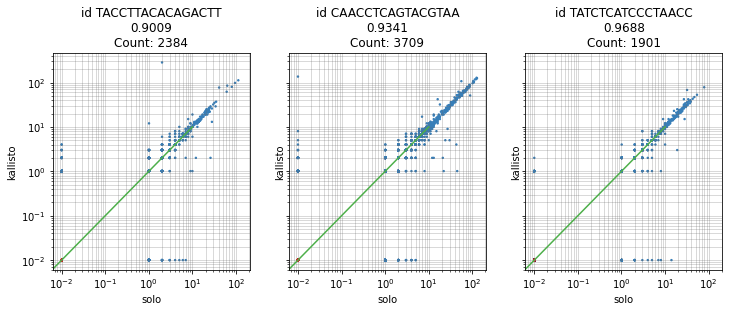

In [22]:
show_scatter_extremes(tenx_datasets, tenx_cors, 'solo', 'kallisto')

## 10x minimal alevin vs kallisto

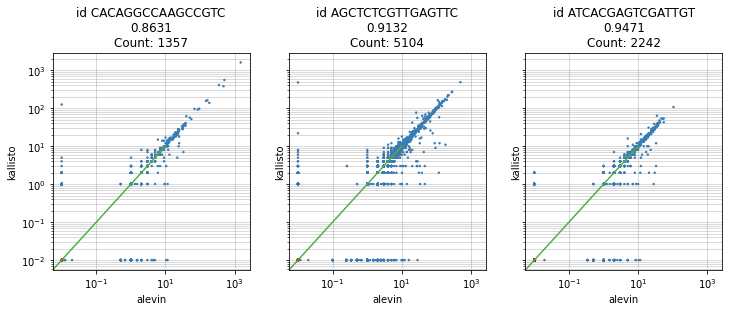

In [23]:
show_scatter_extremes(tenx_datasets, tenx_cors, 'alevin', 'kallisto')

# Compare C1 minimal

In [24]:
c1_pseudo = Path('c1_pseudo')

In [25]:
c1_gene_counts = {
    'star_minimal': scanpy.read_h5ad(c1_pseudo / 'star_minimal_gene_counts.h5ad').to_df().T,
    'kallisto_minimal': scanpy.read_h5ad(c1_pseudo / 'kallisto_minimal_gene_counts.h5ad').to_df().T,
    'alevin_minimal': scanpy.read_h5ad(c1_pseudo / 'salmon_minimal_gene_counts.h5ad').to_df().T,
}

In [26]:
c1_gene_count_cors = cors = compute_correlations(c1_gene_counts)

## C1 spearman correlation histogram

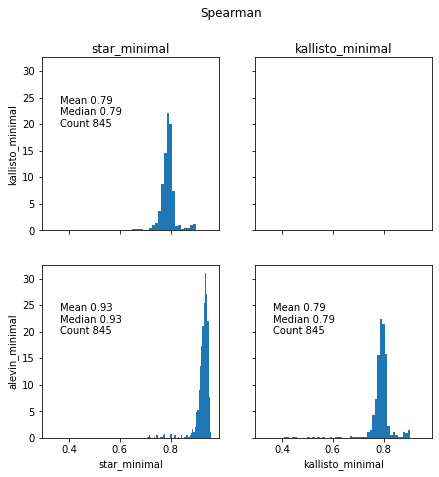

In [27]:
plot_cell_correlation_histogram(c1_gene_count_cors)

Show scatter plots of two algorithms on the same cell, I chose the worst, median, and best spearman correlations. The header is cell ID, spearmen correlation, and how many gtf annotations are shown on the plot. Points colored red are the ERCC spike ins

## C1 star minimal vs kallisto minimal

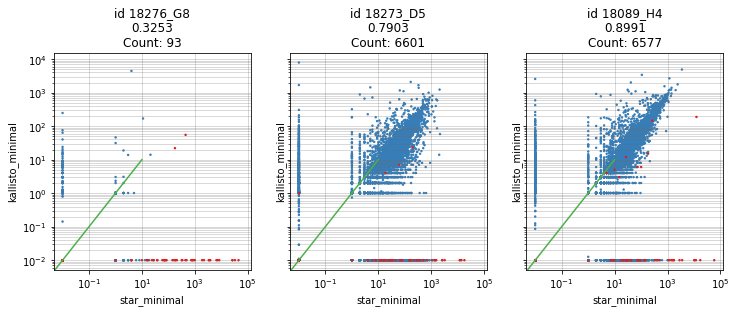

In [28]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, 'star_minimal', 'kallisto_minimal')

## C1 minimal star vs alevin

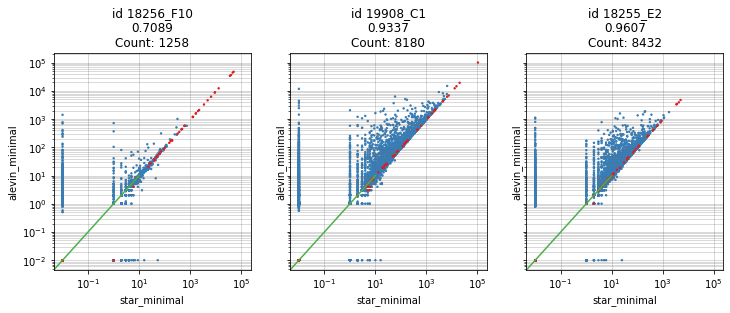

In [29]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, 'star_minimal', 'alevin_minimal')

## C1 star kallisto vs alevin

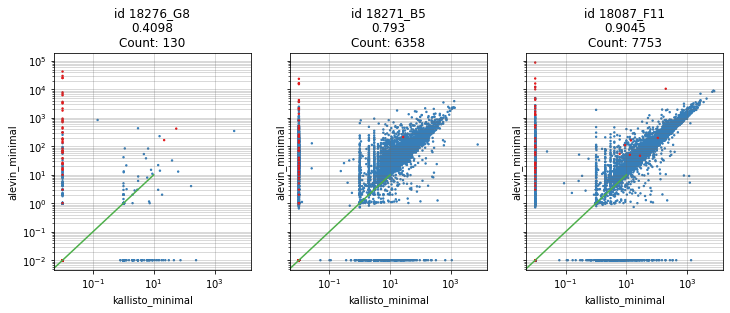

In [30]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, 'kallisto_minimal', 'alevin_minimal')